<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/master/CDR_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 6.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=78f3c1a21c38eec07d2a94725ce0c06b3ac5386167f46c8ea3bbd548659b9c13
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 12.7MB/s]


In [5]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
df_cross

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0


In [7]:
df_long = pd.read_csv('oasis_longitudinal.csv')
df_long

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


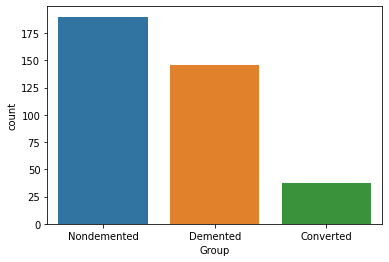

In [8]:
sns.countplot(df_long['Group'])

In [9]:
df_converted = df_long[df_long['Group']=='Converted']
df_converted.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,OAS2_0018_MR1,Converted,1,0,F,R,87,14,1.0,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,OAS2_0018_MR4,Converted,4,1933,F,R,92,14,1.0,27.0,0.5,1423,0.696,1.234
36,OAS2_0020,OAS2_0020_MR1,Converted,1,0,M,R,80,20,1.0,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,OAS2_0020_MR2,Converted,2,756,M,R,82,20,1.0,28.0,0.5,1606,0.677,1.093


In [38]:
df_long['Group'] = df_long['Group'].replace(['Converted'], 'Demented')
df_long

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


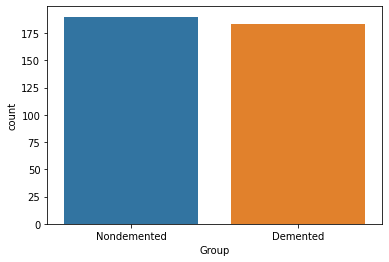

In [39]:
sns.countplot(df_long['Group'])

In [134]:
category = df_long['Group'].replace(['Demented', 'Nondemented'], [1, 0])
gender = pd.get_dummies(df_long['M/F'])

df = df_long.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Group', 'M/F', 'Hand', 'eTIV', 'nWBV', 'ASF'])
df = pd.concat([df, gender, category], axis=1)
df

,Age,EDUC,SES,MMSE,CDR,F,M,Group
0,87,14,2.0,27.0,0.0,0,1,0
1,88,14,2.0,30.0,0.0,0,1,0
2,75,12,NaN,23.0,0.5,0,1,1
3,76,12,NaN,28.0,0.5,0,1,1
4,80,12,NaN,22.0,0.5,0,1,1
...,...,...,...,...,...,...,...,...
368,82,16,1.0,28.0,0.5,0,1,1
369,86,16,1.0,26.0,0.5,0,1,1
370,61,13,2.0,30.0,0.0,1,0,0
371,63,13,2.0,30.0,0.0,1,0,0


In [135]:
df.isnull().sum()

Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
F         0
M         0
Group     0
dtype: int64

In [136]:
df_null = df[df.isnull().any(axis=1)]
df_null

,Age,EDUC,SES,MMSE,CDR,F,M,Group
2,75,12,NaN,23.0,0.5,0,1,1
3,76,12,NaN,28.0,0.5,0,1,1
4,80,12,NaN,22.0,0.5,0,1,1
10,71,16,NaN,28.0,0.5,0,1,1
11,73,16,NaN,27.0,1.0,0,1,1
12,75,16,NaN,27.0,1.0,0,1,1
134,80,12,NaN,30.0,0.5,1,0,1
135,81,12,NaN,27.0,0.5,1,0,1
207,80,12,NaN,27.0,0.5,1,0,1
208,83,12,NaN,23.0,0.5,1,0,1


In [137]:
df_demented = df[df['Group'] == 1]
df_demented.head()

,Age,EDUC,SES,MMSE,CDR,F,M,Group
2,75,12,NaN,23.0,0.5,0,1,1
3,76,12,NaN,28.0,0.5,0,1,1
4,80,12,NaN,22.0,0.5,0,1,1
10,71,16,NaN,28.0,0.5,0,1,1
11,73,16,NaN,27.0,1.0,0,1,1


In [138]:
mean_mmse_demented = df_demented['MMSE'].mean()
mean_ses_demented = df_demented['SES'].mean()
print(round(mean_mmse_demented))
print(round(mean_ses_demented))

25
3


In [139]:
df['MMSE'].fillna(round(mean_mmse_demented), inplace=True)
df['SES'].fillna(round(mean_ses_demented), inplace=True)
df.isnull().sum()

Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
F        0
M        0
Group    0
dtype: int64

In [140]:
df.loc[(df['MMSE'] >= 24) & (df['MMSE'] <= 30), 'Interpreted'] = "Normal"
df.loc[(df['MMSE'] >= 19) & (df['MMSE'] <= 23), 'Interpreted'] = "Mild"
df.loc[(df['MMSE'] >= 10) & (df['MMSE'] <= 18), 'Interpreted'] = "Moderate"
df.loc[(df['MMSE'] >= 0) & (df['MMSE'] <= 9), 'Interpreted'] = "Severe"
df

,Age,EDUC,SES,MMSE,CDR,F,M,Group,Interpreted
0,87,14,2.0,27.0,0.0,0,1,0,Normal
1,88,14,2.0,30.0,0.0,0,1,0,Normal
2,75,12,3.0,23.0,0.5,0,1,1,Mild
3,76,12,3.0,28.0,0.5,0,1,1,Normal
4,80,12,3.0,22.0,0.5,0,1,1,Mild
...,...,...,...,...,...,...,...,...,...
368,82,16,1.0,28.0,0.5,0,1,1,Normal
369,86,16,1.0,26.0,0.5,0,1,1,Normal
370,61,13,2.0,30.0,0.0,1,0,0,Normal
371,63,13,2.0,30.0,0.0,1,0,0,Normal


In [165]:
interpreted = pd.get_dummies(df['Interpreted'])

df_inter = df.drop(columns=['Interpreted'])
df_inter = pd.concat([df_inter, interpreted], axis=1)
df_inter

,Age,EDUC,SES,MMSE,CDR,F,M,Group,Mild,Moderate,Normal,Severe
0,87,14,2.0,27.0,0.0,0,1,0,0,0,1,0
1,88,14,2.0,30.0,0.0,0,1,0,0,0,1,0
2,75,12,3.0,23.0,0.5,0,1,1,1,0,0,0
3,76,12,3.0,28.0,0.5,0,1,1,0,0,1,0
4,80,12,3.0,22.0,0.5,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
368,82,16,1.0,28.0,0.5,0,1,1,0,0,1,0
369,86,16,1.0,26.0,0.5,0,1,1,0,0,1,0
370,61,13,2.0,30.0,0.0,1,0,0,0,0,1,0
371,63,13,2.0,30.0,0.0,1,0,0,0,0,1,0


In [168]:
x = df_inter[['Age',	'M', 'F', 'EDUC', 'SES', 'MMSE', 'Severe', 'Moderate',	'Mild',	'Normal']].values # visit
y = df_inter[['CDR']].values # Group, CDR

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [170]:
print(x_train.shape)
print(x_test.shape)

(335, 10)
(38, 10)


In [173]:
scaler = MinMaxScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled

array([[0.65789474, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.23684211, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.65789474, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.57894737, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.76315789, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.23684211, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [174]:
model_regression = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[10], activation='linear') # 
])

model_regression.compile(
    loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [176]:
# class StopTraining(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     accuracy = 0.76
#     if(logs.get('accuracy') >= accuracy and logs.get('val_accuracy') >= accuracy):
#       print('\nSudah mencapai akurasi {}%, proses training berhenti'.format(accuracy*100))
#       self.model.stop_training = True

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=100) # , baseline=0.03
# st = StopTraining()

In [177]:
history = model_regression.fit(x_train_scaled, y_train, epochs=1500, validation_data=(x_test_scaled, y_test), callbacks=[mc, es], verbose=2)

Epoch 1/1500
11/11 - 0s - loss: 0.2900 - mae: 0.6241 - mse: 0.6698 - val_loss: 0.2513 - val_mae: 0.5689 - val_mse: 0.5521
Epoch 2/1500
11/11 - 0s - loss: 0.2634 - mae: 0.5678 - mse: 0.6067 - val_loss: 0.2268 - val_mae: 0.5169 - val_mse: 0.4959
Epoch 3/1500
11/11 - 0s - loss: 0.2392 - mae: 0.5163 - mse: 0.5486 - val_loss: 0.2061 - val_mae: 0.4705 - val_mse: 0.4484
Epoch 4/1500
11/11 - 0s - loss: 0.2185 - mae: 0.4743 - mse: 0.4991 - val_loss: 0.1889 - val_mae: 0.4350 - val_mse: 0.4089
Epoch 5/1500
11/11 - 0s - loss: 0.2015 - mae: 0.4414 - mse: 0.4581 - val_loss: 0.1743 - val_mae: 0.4081 - val_mse: 0.3755
Epoch 6/1500
11/11 - 0s - loss: 0.1873 - mae: 0.4202 - mse: 0.4242 - val_loss: 0.1621 - val_mae: 0.3886 - val_mse: 0.3474
Epoch 7/1500
11/11 - 0s - loss: 0.1753 - mae: 0.4041 - mse: 0.3955 - val_loss: 0.1523 - val_mae: 0.3766 - val_mse: 0.3247
Epoch 8/1500
11/11 - 0s - loss: 0.1659 - mae: 0.3948 - mse: 0.3723 - val_loss: 0.1444 - val_mae: 0.3689 - val_mse: 0.3063
Epoch 9/1500
11/11 - 0s 

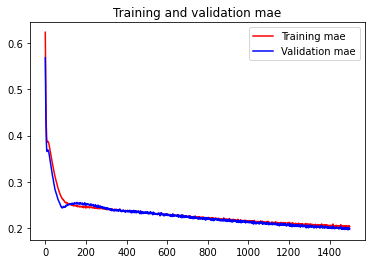

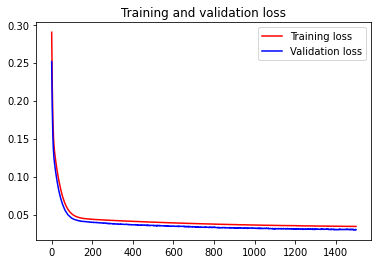

In [178]:
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [179]:
saved_model = load_model('best_model.h5')

loss, mae, mse = saved_model.evaluate(x_test_scaled, y_test)
print("Mae: ", loss)

2/2 [==============================] - 0s 4ms/step - loss: 0.0298 - mae: 0.1956 - mse: 0.0596
Mae:  0.029775654897093773


In [180]:
print(model_regression.predict(scaler.transform([[75, 0, 1, 12, 2.0, 23.0, 0, 0, 1, 0]])))
print(model_regression.predict(scaler.transform([[87, 0, 1, 14, 2.0, 27.0, 0, 0, 0, 1]])))

[[0.63752455]]
[[0.27989656]]


In [ ]:
class EarlyStop(tf.keras.callbacks.Callback):
  def __init__(self, threshold=0.95, patience=3, significance_val=0.001):
    super(EarlyStop, self).__init__()

    self.threshold = threshold                                                    
    self.patience = patience                                                      
    self.significance_val = significance_val                                      
    self.best_weights = None                                                      
    self.is_reach_threshold = False                                               
    self.best_epoch = 0                                                           

  def on_train_begin(self, logs=None):
    self.previous_acc = 0                                                         
    self.wait = 0                                                                 

  def on_epoch_end(self, epoch, logs={}):
    self.current_acc = logs.get('val_accuracy')                                   

    if self.is_reach_threshold:
      if self.current_acc - self.previous_acc > self.significance_val:
        self.wait = 0
        self.previous_acc = self.current_acc
        self.best_weights = self.model.get_weights()
        self.best_epoch = epoch
        print('\n[INFO] Update weights terbaik!')
      else:
        self.wait += 1
        print(f'\n[INFO] Nilai patience sekarang = {self.wait}')
        if self.wait >= self.patience:
          self.model.stop_training = True
          print(f'\n[INFO] Validation Accuracy tidak bertambah setelah epochs ke-{self.patience}, sehingga training dihentikan.')
          self.model.set_weights(self.best_weights)
          print(f'\n[INFO] Mengembalikan nilai weights terbaik dari epoch ke-{self.best_epoch + 1} val_acc')
    
    if self.current_acc > self.threshold and not self.is_reach_threshold:
      self.is_reach_threshold = True
      self.previous_acc = self.current_acc
      self.best_weights = self.model.get_weights()
      self.best_epoch = epoch
      print('\n[INFO] Threshold tercapai! Nilai weights terbaik mulai dari sini.')